# Working with lat-lon coordinates

In the previous sections we have considered grid point positions `coords` given as euclidean coordinates. However, it is common that we have coordinates given as latitudes and longitudes. This notebooks describes how we can constuct graphs directly using lat-lon coordinates. This is achieved by also providing a specific projection, used to project the lat-lons to a euclidean space where the graph can be construced.

## A motivating example

Let's start by defining some example lat-lons to use in our example. When using lat-lons the first column of `coords` should contain longitudes and the second column latitudes.

In the example below we create lat-lons laid out around the top of the globe. These example points are equidistantly spaced, but this does not have to be the case.

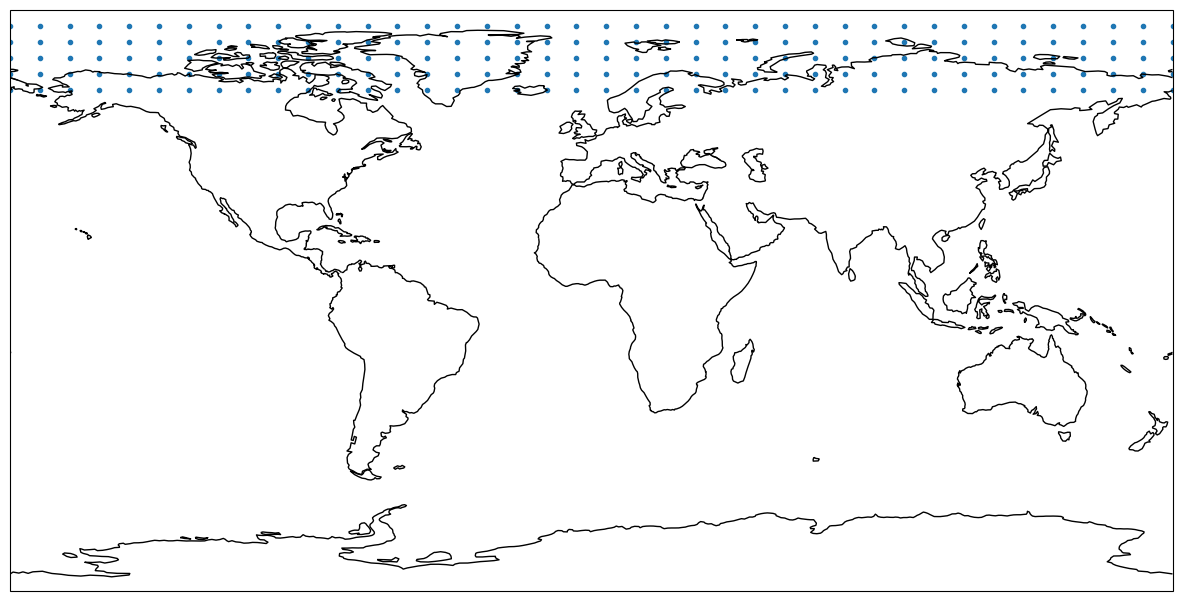

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

longitudes = np.linspace(-180, 180, 40)
latitudes = np.linspace(65, 85, 5) # Very close to north pole

meshgridded_lat_lons = np.meshgrid(longitudes, latitudes)
coords = np.stack([mg_coord.flatten() for mg_coord in meshgridded_lat_lons], axis=1)

fig, ax = plt.subplots(figsize=(15,9), subplot_kw={'projection': ccrs.PlateCarree()})
ax.scatter(coords[:, 0], coords[:, 1], marker=".")
ax.coastlines()
ax.set_extent((-180, 180, -90, 90))

We first consider what happens if we directly feed these lat-lons as `coords`, treating them as if they were euclidean coordinates. In this notebook we will only create flat "Keisler-like" graphs, but everything works analogously for the other graph types.

2024-10-16 17:09:06.497 | DEBUG    | weather_model_graphs.create.base:create_all_graph_components:87 - No `projection` given: Assuming `coords` contains in-projection euclidean coordinates.


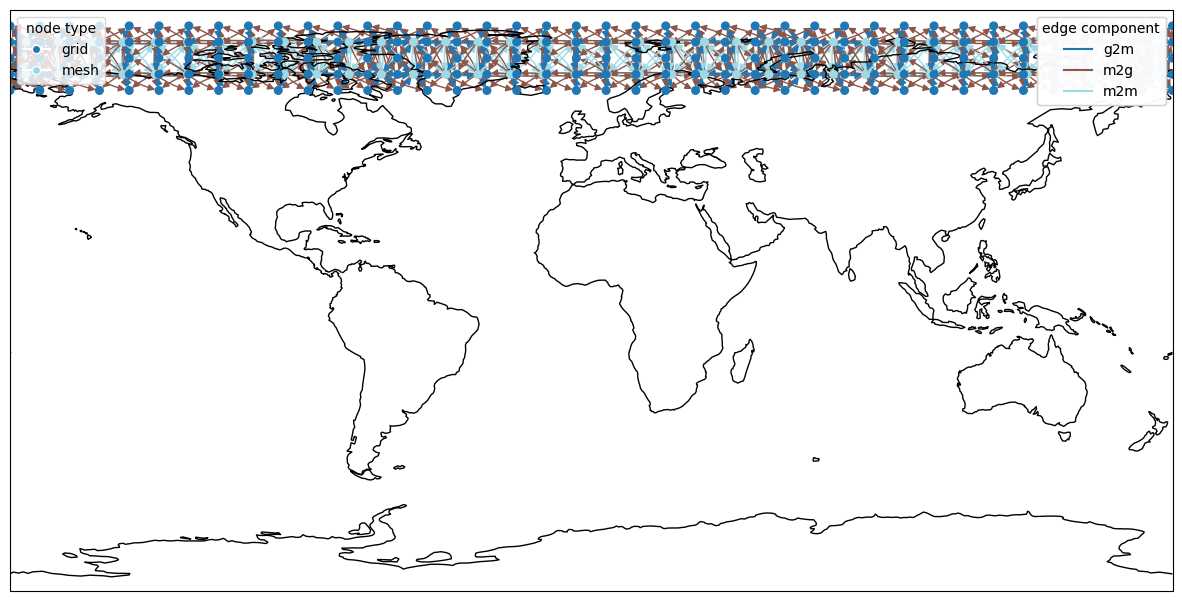

In [54]:
import weather_model_graphs as wmg

graph = wmg.create.archetype.create_keisler_graph(coords, mesh_node_distance=10)
fig, ax = plt.subplots(figsize=(15,9), subplot_kw={'projection': ccrs.PlateCarree()})
wmg.visualise.nx_draw_with_pos_and_attr(
    graph, ax=ax, node_size=30, edge_color_attr="component", node_color_attr="type"
)
ax.coastlines()
ax.set_extent((-180, 180, -90, 90))

This creates a useable mesh graph, but we can note a few problems with it:

* There are no connections between nodes around longitude -180/180, i.e. the periodicity of longitude is not considered.
* All nodes at the top of the plot, close to the pole, are actually very close spatially. Yet there are no connections between them.

These are issues both in the connection between the grid nodes and the mesh, and in the connections between mesh nodes. This points to the fact that we should probably use a different projection when building our graph. 

## Constructing a graph within a projection
For our example above, let's instead try to construct the graph based on first projecting our lat-lon coordinates to within a specific projection. This can be done by giving a `projection` argument to the graph creation functions. The projection should be an instance of `cartopy.crs.CRS`. See [the cartopy documentation](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html) for a list of available projections. 

We will here try the same thing as above, but using a Azimuthal equidistant projection centered at the pole:

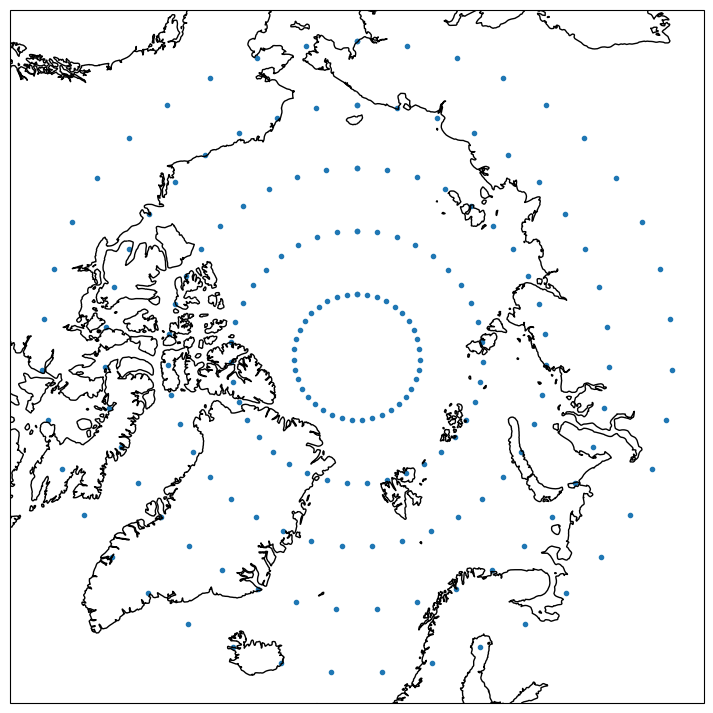

In [55]:
# Define our projection
ae_projection = ccrs.AzimuthalEquidistant(central_latitude=90)

fig, ax = plt.subplots(figsize=(15,9), subplot_kw={'projection': ae_projection})
ax.scatter(coords[:, 0], coords[:, 1], marker=".", transform=ccrs.PlateCarree())
_ = ax.coastlines()

Note that distances within projections tend to have very large magnitudes, so the distance between mesh nodes should be specified accordingly.

2024-10-16 17:07:16.829 | DEBUG    | weather_model_graphs.create.base:create_all_graph_components:92 - `projection` Proj(+proj=aeqd +ellps=WGS84 +lon_0=0.0 +lat_0=90 +x_0=0.0 +y_0=0.0 +no_defs +type=crs) given, `coords` treated as lat-lons.


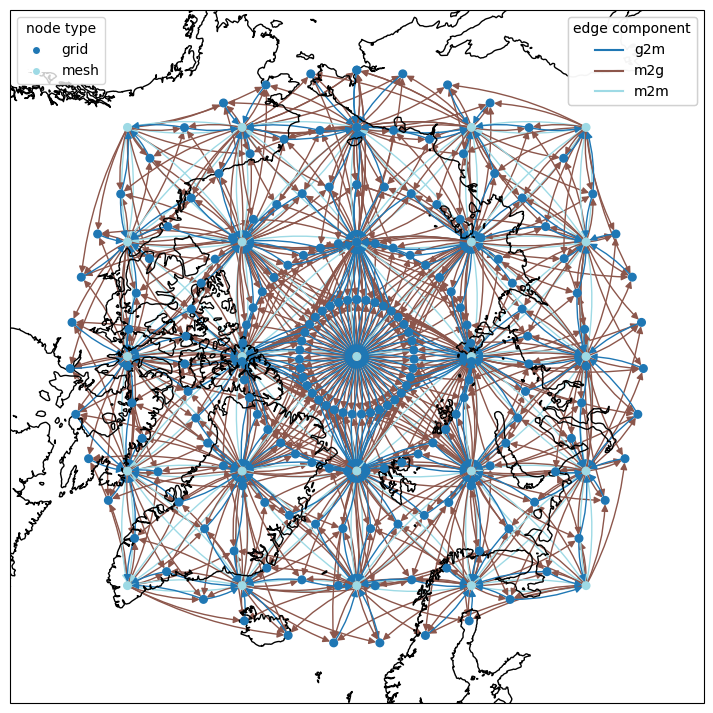

In [52]:
mesh_distance = 10**6 # Large euclidean distance in projection coordinates between mesh nodes
graph = wmg.create.archetype.create_keisler_graph(coords, mesh_node_distance=mesh_distance, projection=ae_projection) # Note that we here specify the projection argument
fig, ax = plt.subplots(figsize=(15,9), subplot_kw={'projection': ae_projection})
wmg.visualise.nx_draw_with_pos_and_attr(
    graph, ax=ax, node_size=30, edge_color_attr="component", node_color_attr="type"
)
_ = ax.coastlines()

Now this looks like a more reasonable graph layout, that better respects the spatial relations between the grid points. There are still things that could be tweaked further (e.g. the large number of grid nodes connected to the center mesh node), but this ends our example of defining graphs using lat-lon coordinates.